In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import timm
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from emsim.geant.dataset import (
    GeantElectronDataset,
    electron_collate_fn,
    plot_pixel_patch_and_points,
)
from emsim.geant.incidence_predictor import (
    GaussianIncidencePointPredictor,
    IncidencePointPredictor,
    eval_gaussian_model,
    eval_pointwise_model,
    fit_gaussian_patch_predictor,
    fit_pointwise_patch_predictor,
)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [3]:
pixels_file = "../data/pixelated_5um_tracks_thinned_4um_back_20k_300keV.txt"
trajectory_file = "../data/e300keV_thinned_4um_back_20k.txt"

### This value controls the background noise level

In [4]:
noise_std = 8

### Create training and test datasets

In [5]:
dataset = GeantElectronDataset(pixels_file, [128, 129], 7, noise_std=noise_std, trajectory_file=trajectory_file)
test_dataset = GeantElectronDataset(pixels_file, [128, 129], 7, noise_std=noise_std, trajectory_file=trajectory_file, split="test")

### Generate a test batch for debugging and plotting later

In [6]:
test_loader = DataLoader(test_dataset, 1, collate_fn=electron_collate_fn)
test_batch = next(iter(test_loader))

### This creates an instance of the non-uncertainty-aware incidence point predictor

In [7]:
backbone = timm.create_model("resnet18", in_chans=1, num_classes=0)
model = IncidencePointPredictor(backbone).to(device)

### Train the non-uncertainty-aware incidence point predictor

In [8]:
fit_pointwise_patch_predictor(model, dataset, n_steps=1000)

100%|██████████| 1000/1000 [06:17<00:00,  2.65it/s, loss=0.00542]


### Evaluate it on the test dataset

In [9]:
nn_errors, com_errors, nn_distances, com_distances = eval_pointwise_model(model, test_dataset)

In [10]:
# Print results
print(f"{nn_distances.mean()=}")
print(f"{com_distances.mean()=}")

nn_distances.mean()=0.7220473149486164
com_distances.mean()=0.8323876620991825


### Plot an example prediction from the test dataset

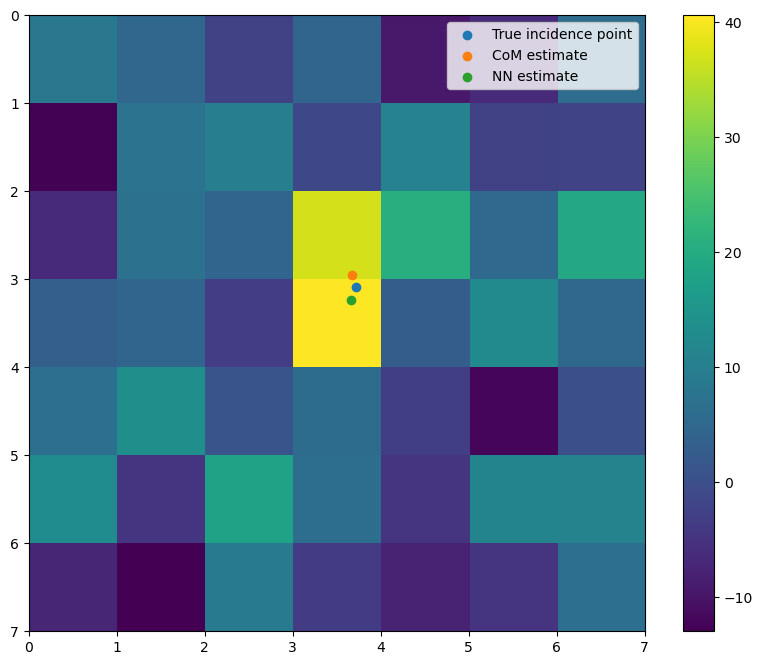

In [11]:
# This selects which element from the test batch to plot
i = 34


model.eval()
with torch.no_grad():
    predicted_point = model(test_batch["pixel_patches"][i].unsqueeze(0).to(device)).cpu().numpy().squeeze()
    
fig, ax = plot_pixel_patch_and_points(
    test_batch["pixel_patches"][i].numpy(),
    [
        test_batch["local_incidence_points_pixels"][i].numpy(),
        test_batch["local_centers_of_mass_pixels"][i].numpy(),
        predicted_point
    ],
    ["True incidence point", "CoM estimate", "NN estimate"],
)
fig.set_size_inches(10, 8)
fig.show()

### How long does inference take on the test batch?

In [12]:
test_batch_input = test_batch["pixel_patches"].to(device)

In [13]:
%%timeit
result = model(test_batch["pixel_patches"].to(device))

2.75 ms ± 450 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Uncertainty-aware predictor

### Create the backbone and model

In [14]:
backbone = timm.create_model("resnet18", in_chans=1, num_classes=0)
model2 = GaussianIncidencePointPredictor(backbone).to(device)

### Train the model

In [15]:
nll_losses, rmse = fit_gaussian_patch_predictor(model2, dataset, n_steps=1000)

100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s, loss=-.711, rmse=0.344]  


### Evaluate on the test dataset

In [16]:
nn_errors, com_errors, nn_distances, com_distances = eval_gaussian_model(model2, test_dataset)

In [17]:
print(f"{nn_distances.mean()=}")
print(f"{com_distances.mean()=}")

nn_distances.mean()=1.6936612814181171
com_distances.mean()=0.8173109898253504


### Plotting code

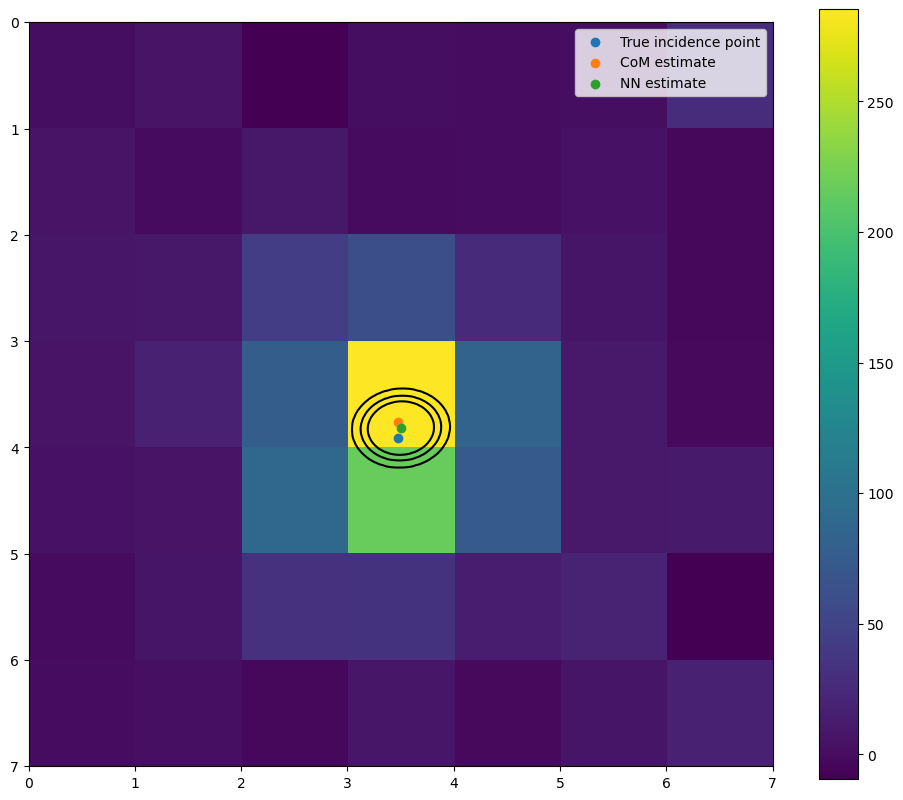

In [19]:
i = 11

model2.eval()
with torch.no_grad():
    dist = model2(test_batch["pixel_patches"].to(device))
    predicted_points = dist.mean.cpu().numpy().squeeze()
    covariances = dist.covariance_matrix.cpu().numpy().squeeze()
    
distances = ((dist.mean - test_batch["local_incidence_points_pixels"].to(device)) ** 2).sum(-1).sqrt()
    
# # Look at the biggest outlier
# i = distances.argmax()
    
X, Y = np.meshgrid(
    np.linspace(0, test_batch["pixel_patches"][i].shape[0], 300),
    np.linspace(0, test_batch["pixel_patches"][i].shape[1], 300),
)
Z = scipy.stats.multivariate_normal.pdf(np.stack([X, Y], -1), mean=predicted_points[i], cov=covariances[i])

fig, ax = plot_pixel_patch_and_points(
    test_batch["pixel_patches"][i].numpy(),
    [
        test_batch["local_incidence_points_pixels"][i].numpy(),
        test_batch["local_centers_of_mass_pixels"][i].numpy(),
        predicted_points[i]
    ],
    ["True incidence point", "CoM estimate", "NN estimate"],
    Z
)
fig.set_size_inches(12, 10)
fig.show()